# Assignment 5: Question 3: SLR Pulse Design



In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys

from scipy.special import j1
def jinc(r):
    #
    return j1(r*np.pi)/(2*r)

def rect(r):
    #1 from -0.5 to 0.5. 
    #rect(r/(2*kmax)) yields 1 from -kmax to kmax. 
    return 0.5*(np.sign(r+0.5) + np.sign(0.5 - r))

def wsinc(timebandwidth, samples):
    #windowed sinc
    #for sincs, timebandwidth product is twice the number of zero crossings.
    n = timebandwidth/2#num zeros
    time = np.linspace(-n, n, samples)
    rf = sp.special.sinc(time)
    window = sp.signal.hamming(samples)
    rf = rf*window
    rf = rf/ rf.sum() #normalize
    return rf

def rf_scale_g(rf, pulse_duration):
    gyro = 4257 #hz/gauss
    #scale rf to have its amplitude in Gauss. 
    #sum of a waveform is its final flip angle. 
    #rf[k] = 'small flip angle' = gyro*B1[k]*dt 
    dt = pulse_duration/len(rf)
    B1 = rf/gyro/dt 
    #B1= B1T * 1E4 # 1T = 10,000 Gauss
    return B1

def gt2cm(x,g,t):
    #converts unitless spatial x vector to spatial position in cm. 
    #  g == G/ cm 
    #  t == ms
    # grad area:
    g_area = g*t * 1E-3 #converts ms to S.
    gyro = 4257 #hz/gauss
    kmax = gyro/(2*np.pi)*g_area *1/2 # Area under slice select lobe is 2kmax.
    #question, when does gyro come in? 
    dx = 1/(2*kmax) 
    x_cm = x*dx
    return x_cm

a) Design a TBW=8 windowed sinc RF pulse, and scale it to a π radian rotation. Plot the RF
pulse scaled to Gauss. Assume a pulse length of 8 ms, and a gradient strength of 0.425 G/cm.
Simulate and plot the inversion profile. Choose an interesting range of spatial locations, and
compute the inversion profile with
>> mz = ab2inv(abrm(rf,x))

In [5]:
from ab2ex import *
from abrm import *
from ab2inv import *
from ab2rf import *
from mag2mp import *
from b2a import *

/tmp/ipykernel_118039/1281201082.py:22: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated since SciPy 1.1.0 and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  window = sp.signal.hamming(samples)


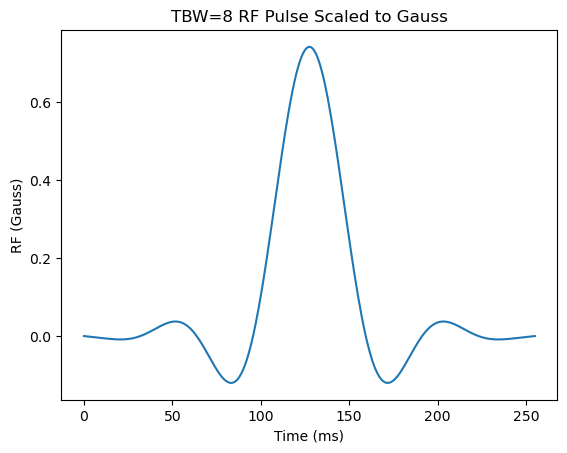

In [9]:

tbw = 8
wsinc8 = wsinc(tbw, 256)*np.pi # TBW=8, scaled to pi radians. 
pulse_duration = 8e-3
rf_gauss = rf_scale_g(wsinc8, pulse_duration) #
plt.plot(rf_gauss)
plt.xlabel('Time (ms)')
plt.ylabel('RF (Gauss)')
plt.title(f'TBW={tbw} RF Pulse Scaled to Gauss')
plt.show()




/tmp/ipykernel_118039/1281201082.py:22: DeprecationWarning:

Importing hamming from 'scipy.signal' is deprecated since SciPy 1.1.0 and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.

/root/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning:

Casting complex values to real discards the imaginary part

/root/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning:

Casting complex values to real discards the imaginary part



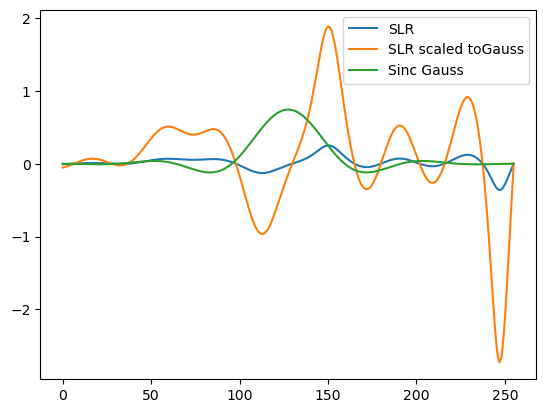

In [46]:




tbw = 8
wsinc8 = wsinc(tbw, 256)# TBW=8
beta = wsinc8*np.sin( (np.pi/2) /2) #scale beta polynomials by sin(theta/2)  
alpha = b2a(beta) #Create min phase and min power alpha polynomials via analytic signals (hilbert transform) 
rf_slr = ab2rf(alpha, beta) #Create rf waveform from alpha and beta polynomials. 
rf_slr_gauss = rf_scale_g(rf_slr, pulse_duration) #


plt.plot(rf_slr, label='SLR')
plt.plot(rf_slr_gauss, label='SLR scaled toGauss')
plt.plot(rf_gauss, label='Sinc Gauss')
plt.legend()
plt.show()




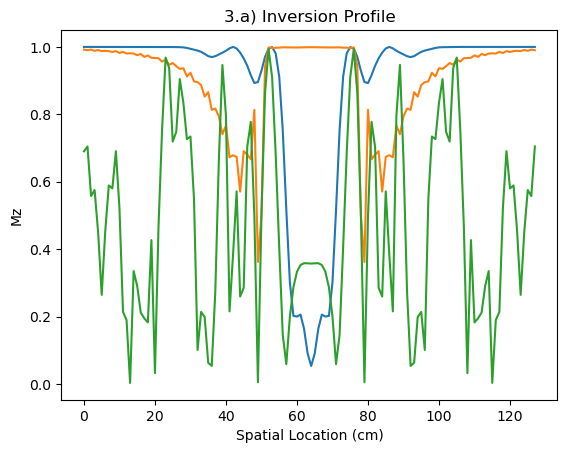

In [47]:

v = np.arange(-64,64) #unitless voxels
g = 0.425
x = gt2cm(v, g, pulse_duration*1E3) #cm


a,b = abrm(rf_gauss, x)
mz = ab2inv(a,b)
a,b = abrm(rf_slr, x)
mz_slr = ab2inv(a,b)
a,b = abrm(rf_slr_gauss, x)
mz_slr_gauss = ab2inv(a,b)


plt.plot(np.abs(mz))
plt.plot(np.abs(mz_slr))
plt.plot(np.abs(mz_slr_gauss))
plt.xlabel('Spatial Location (cm)')
plt.ylabel('Mz')
plt.title('3.a) Inversion Profile')
plt.show()

In [ ]:
import plotly.graph_objects as go

# Create scaling factors from 0.1 to 10
scale_factors = np.linspace(0.1, 10, 50)  # 0.1 to 10, 50 points

# Compute inversion profiles for each scaling factor
inversion_profiles = []
for scale in scale_factors:
    rf_scaled = rf_slr_gauss * scale
    a, b = abrm(rf_scaled, x)
    mz_scaled = ab2inv(a, b)
    inversion_profiles.append(np.abs(mz_scaled))

# Convert to numpy array and ensure real values (convert complex to real)
inversion_profiles = np.array(inversion_profiles)
inversion_profiles = np.real(inversion_profiles)  # Convert to real values



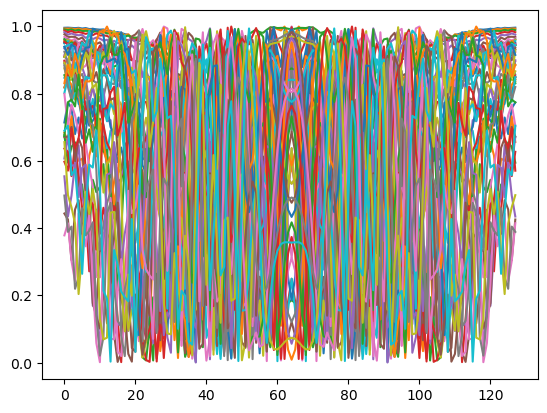

In [44]:
for i in range(len(inversion_profiles)):
    plt.plot(inversion_profiles[i])


In [ ]:

# Ensure x is a 1D array and squeeze inversion_profiles if needed
x = np.asarray(x).flatten()
inversion_profiles = np.squeeze(inversion_profiles)

# Create wireframe plot
fig = go.Figure()

# Plot profiles as lines (along x-axis for each scaling factor)
step = max(1, len(scale_factors) // 10)
for i in range(0, len(scale_factors), step):
    fig.add_trace(go.Scatter3d(
        x=x,
        y=[scale_factors[i]] * len(x),
        z=inversion_profiles[i],
        mode='lines',
        line=dict(color='blue', width=2),
        showlegend=False
    ))


# # Plot lines along scaling factor dimension
# x_step = max(1, len(x) // 10)
# for i in range(0, len(x), x_step):
#     fig.add_trace(go.Scatter3d(
#         x=[x[i]] * len(scale_factors),
#         y=scale_factors,
#         z=inversion_profiles[:, i],
#         mode='lines',
#         line=dict(color='red', width=1),
#         showlegend=False
#     ))

fig.update_layout(
    title='Inversion Profile Evolution with RF Scaling (Wireframe)',
    scene=dict(
        xaxis_title='Spatial Position (cm)',
        yaxis_title='Scaling Factor',
        zaxis_title='Mz (Inversion Profile)'
    ),
    width=900,
    height=700
)

fig.show()
